## Imports

In [138]:
import pandas as pd
from random import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy import constants
from scipy.optimize import leastsq
from scipy import stats
from lmfit import minimize, Parameters, report_fit
%matplotlib inline
    
plt.rcParams['figure.figsize'] = (20, 10)
pd.options.mode.chained_assignment = None  # default='warn'

## Functions

In [139]:
def abline(slope, intercept, lcol):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, lcol)

## Sort Data

In [140]:
k = constants.value('Boltzmann constant in eV/K')
e = np.exp(1)

GRDF = pd.read_csv("../Data/GrowthRespPhotoData_new.csv",
                   usecols = ["FinalID",
                              "StandardisedTraitName",
                              "StandardisedTraitDef",
                              "StandardisedTraitValue",
                              "StandardisedTraitUnit",
                              "AmbientTemp",
                              "AmbientTempUnit",
                              "ConTemp",
                              "ConTempUnit",
                              "ResTemp",
                              "ResTempUnit"],
                   low_memory = False)

# get rid of 0s -ves and NAs from data (only +ves)
GRDF = GRDF.iloc[GRDF.index[GRDF["StandardisedTraitValue"] > 0]]

# create NewID based on FianlID
GRDF["NewID"] = GRDF.FinalID.astype("category").cat.codes

# sort by NewID then ConTemp; AmbientTemp; ResTemp  *SHOULD ASK SAMRAAT ABOUT WHICH TEMP TO USE*
GRDF = GRDF.sort_values(['NewID', 'ConTemp', 'AmbientTemp', 'ResTemp'])

# reset index
GRDF = GRDF.reset_index(drop = True)

# go through each id and if the first value it > 5 times higher than the next then delete the row...
for id in GRDF.NewID.unique():
    tmp = GRDF[GRDF.NewID == id]
    tmp = tmp.reset_index(drop = True)
    
    try:
        if tmp.StandardisedTraitValue[0] > 3*tmp.StandardisedTraitValue[1]:
            GRDF = GRDF.drop(GRDF.index[GRDF.NewID == id][0])
    except KeyError:
        pass
    

# get rid of ids with < 5 data points
GRDF = GRDF.groupby("FinalID").filter(lambda x: len(x) > 5)

# convert to kelvin
GRDF.ConTempUnit     = GRDF.ConTempUnit.str.lower()
GRDF.AmbientTempUnit = GRDF.AmbientTempUnit.str.lower()
GRDF.ResTempUnit     = GRDF.ResTempUnit.str.lower()

GRDF.ConTemp[GRDF.ConTempUnit != "kelvin"]         = GRDF.ConTemp[GRDF.ConTempUnit != "kelvin"] + 273.15
GRDF.AmbientTemp[GRDF.AmbientTempUnit != "kelvin"] = GRDF.AmbientTemp[GRDF.AmbientTempUnit != "kelvin"] + 273.15
GRDF.ResTemp[GRDF.ResTempUnit != "kelvin"]         = GRDF.ResTemp[GRDF.ResTempUnit != "kelvin"] + 273.15
    
# only columns i need
GRDF = GRDF.loc[ : ,("NewID",
                     "FinalID",
                     "StandardisedTraitName",
                     "StandardisedTraitDef",
                     "StandardisedTraitValue",
                     "StandardisedTraitUnit",
                     "AmbientTemp",
                     "ConTemp",
                     "ResTemp")]

# logged trait value
GRDF["STVlogged"] = np.log(GRDF.StandardisedTraitValue)

# reset index
GRDF = GRDF.reset_index(drop = True)

## Choose a Curve and get starting values

<function matplotlib.pyplot.show>

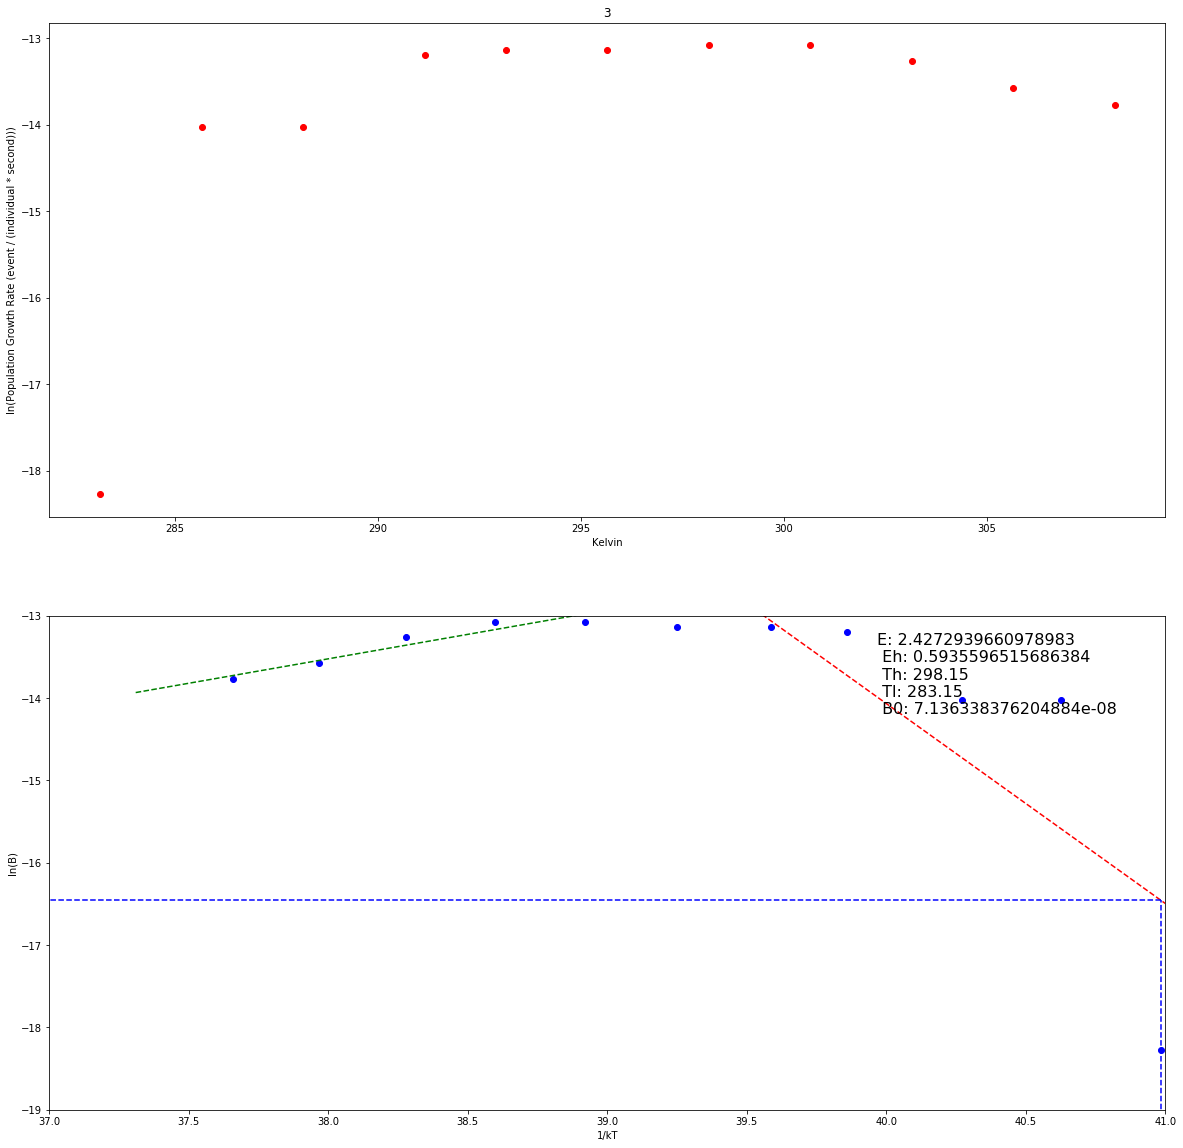

In [163]:
id = 3

# which temperature measure to use? ConTemp > AmbientTemp > ResTemp
curveDF = GRDF[GRDF["NewID"] == id]

if curveDF["ConTemp"].isnull().any() == False:
    xVals   = np.asarray(curveDF["ConTemp"])
elif curveDF["AmbientTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("AmbientTemp")
    xVals   = np.asarray(curveDF["AmbientTemp"])
elif curveDF["ResTemp"].isnull().any() == False:
    curveDF = curveDF.sort_values("ResTemp")
    xVals   = np.asarray(curveDF["ResTemp"])

data    = np.asarray(curveDF["StandardisedTraitValue"])
ldata   = np.asarray(curveDF["STVlogged"])

# y axis title is whatever trait unit...
ytitle = ("ln(" + curveDF["StandardisedTraitName"].iloc[0] + " (" +
          curveDF["StandardisedTraitUnit"].iloc[0] + "))")

# Starting Values

# E is the slope of the main bit of the curve when ln(B) is plotted against 1/kT (made positive?)
# use all point past Tpeak (Th) Eh is the slope of the line before these points
split = np.argmax(ldata)  # split
try:
    lm1 = stats.linregress(x = (1/(xVals[:split]*k)), y = ldata[:split])  # E is slope
except ValueError:
    lm1 = stats.linregress(x = (1/(xVals[split:]*k)), y = ldata[split:])  # Eh is slope

try:
    lm2 = stats.linregress(x = (1/(xVals[split:]*k)), y = ldata[split:])  # Eh is slope
except ValueError:
    lm1 = stats.linregress(x = (1/(xVals[:split]*k)), y = ldata[:split])  # E is slope
    
E  = abs(lm1[0])                          # slope of line for points to right of Tpeak
Eh = abs(lm2[0])                          # slope of line for points to left og Tpeak
B0 = e**(lm1[0]*(1/(k*283.15)) + lm1[1])  # y = mx +c to get ln(Bo) at 10 degrees
Th = xVals[np.argmax(ldata)]         # Tpeak
Tl = min(xVals)                      # The lowest temperture value for which there is a trait value
# El I will bind so it must be lower than E in the NLLS

# plots!

plt.figure(figsize = (20, 20))
plt.subplot(211)
plt.plot(xVals, ldata, 'ro')
plt.ylabel(ytitle)
plt.xlabel("Kelvin")
plt.title(id)

plt.subplot(212)
plt.plot((1/(xVals*k)), ldata, 'bo')
abline(slope = lm1[0], intercept = lm1[1], lcol = 'r--')
abline(slope = lm2[0], intercept = lm2[1], lcol = 'g--')
plt.plot(((1/(k*283.15)), (1/(k*283.15))), (-10000, np.log(B0)), 'b--')
plt.plot(((1/(k*283.15)), -10000), (np.log(B0), np.log(B0)), 'b--')
plt.ylim(np.floor(min(ldata)), np.ceil(max(ldata)))
plt.xlim(np.floor(min((1/(xVals*k)))), np.ceil(max((1/(xVals*k)))))
stuff = "E: {} \n Eh: {} \n Th: {} \n Tl: {} \n B0: {}".format(E, Eh, Th, Tl, B0) 
plt.figtext(0.7, 0.4, fontsize = 16, s = stuff)
plt.xlabel("1/kT")
plt.ylabel("ln(B)")

plt.show

## General cubic polynomial model

$$ \large B = B_0 + B_1T + B_2T^2 + B_3T^3 $$

[[Fit Statistics]]
    # function evals   = 84
    # data points      = 11
    # variables        = 4
    chi-square         = 2.910
    reduced chi-square = 0.416
    Akaike info crit   = -6.629
    Bayesian info crit = -5.037
[[Variables]]
    a:  -36809.5843 +/- 1.36e+04 (37.04%) (init= 0)
    b:   368.347826 +/- 138.4594 (37.59%) (init= 0)
    c:  -1.22868309 +/- 0.468500 (38.13%) (init= 0)
    d:   0.00136568 +/- 0.000528 (38.68%) (init= 0)
[[Correlations]] (unreported correlations are <  0.100)
    C(c, d)                      = -1.000 
    C(b, c)                      = -1.000 
    C(a, b)                      = -1.000 
    C(b, d)                      =  1.000 
    C(a, c)                      =  1.000 
    C(a, d)                      = -1.000 


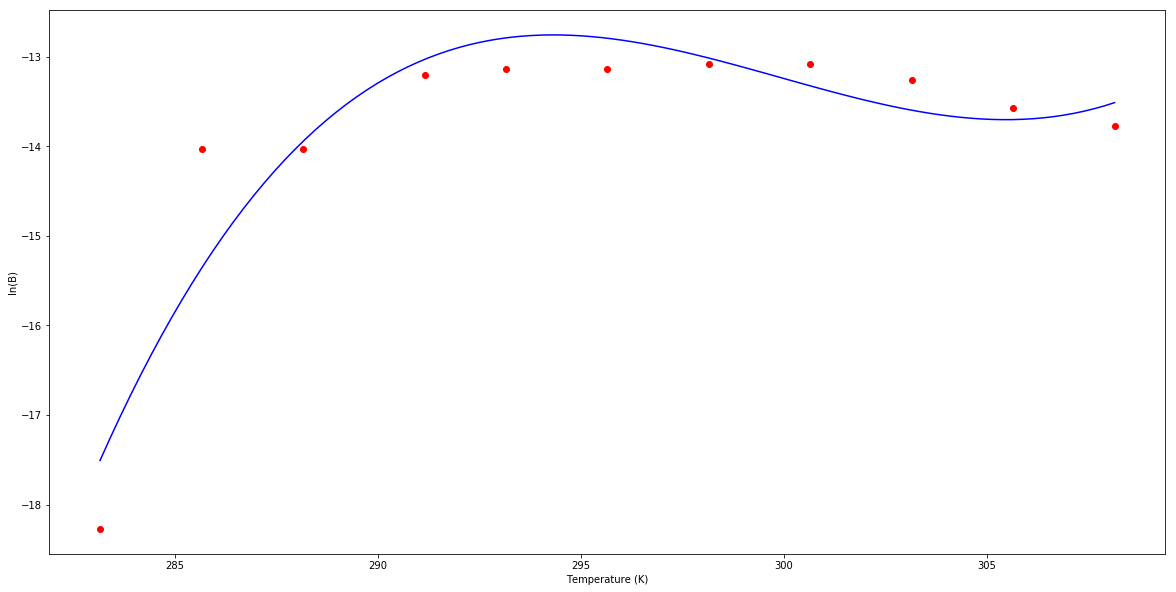

In [164]:
params = Parameters()
params.add('a', value = 0.)
params.add('b', value = 0.)
params.add('c', value = 0.)
params.add('d', value = 0.)

def get_residual(params, x, data):
    a = params['a'].value 
    b = params['b'].value
    c = params['c'].value 
    d = params['d'].value 
    
    model = a + b*x + c*x**2 + d*x**3
    
    return model - data

out1 = minimize(get_residual, params, args = (xVals, ldata))

a = out1.params["a"].value
b = out1.params["b"].value
c = out1.params["c"].value
d = out1.params["d"].value

mdlx = np.linspace(min(xVals), max(xVals), num = 100)
mdly = a + b*mdlx + c*mdlx**2 + d*mdlx**3

report_fit(out1)

plt.plot(xVals, ldata, 'ro')
plt.plot(mdlx, mdly, 'b')
plt.xlabel("Temperature (K)")
plt.ylabel("ln(B)")
plt.show()

## Full Schoolfield Model

$$ \large B = \frac{B_0e^{\frac{-E}{k}(\frac{1}{T} - \frac{1}{283.15})}}{1 + e^{\frac{E_l}{k}(\frac{1}{T_l}-\frac{1}{T})} + e^{\frac{E_h}{k}(\frac{1}{T_h}-\frac{1}{T})}} $$

In [169]:
def schlfld_residual(sparams, x, data):
    B0 = sparams['B0'].value 
    E  = sparams['E'].value 
    El = sparams['El'].value 
    Eh = sparams['Eh'].value
    Tl = sparams['Tl'].value
    Th = sparams['Th'].value
    e  = sparams['e'].value
    k  = sparams['k'].value
    
    model = np.log((B0*e**((-E/k)*((1/x)-(1/283.15))))/(1+(e**((El/k)*((1/Tl)-(1/x))))+(e**((Eh/k)*((1/Th)-(1/x))))))
        
    return model - data

trycount = 0
while True:

    trycount += 1
    print(id, 'Try:', trycount)
    if trycount > 10:
        break
        
    try:
        sparams = Parameters()
        sparams.add('B0', value = uniform(B0*.2, B0*1.8), min = 0)
        sparams.add('E',  value = uniform(E*.2, E*1.8), min= 0)
        sparams.add('El', value = uniform(E*.2, E*1.8), min = 0)
        sparams.add('Eh', value = uniform(Eh*.2, Eh*1.8), min = 0)
        sparams.add('Tl', value = Tl, min = 260, max = 330)
        sparams.add('Th', value = Th, min = 260, max = 330)
        sparams.add('e',  value = e, vary = False)
        sparams.add('k',  value = k, vary = False)

        out2 = minimize(schlfld_residual, sparams, args = (xVals, ldata))
        
        B0 = out2.params["B0"].value
        E  = out2.params["E"].value
        El = out2.params["El"].value
        Eh = out2.params["Eh"].value
        Tl = out2.params["Tl"].value
        Th = out2.params["Th"].value

        mdlx = np.linspace(min(xVals), max(xVals), num = 100)
        mdly = np.log((B0*e**((-E/k)*((1/mdlx)-(1/283.15))))/(1+e**((El/k)*((1/Tl)-(1/mdlx)))+(e**((Eh/k)*((1/Th)-(1/mdlx))))))

        report_fit(out2)

        plt.plot(xVals, ldata, 'ro')
        plt.plot(xVals, ldata, 'ro')
        plt.plot(mdlx, mdly, 'b')
        plt.xlabel("Temperature (K)")
        plt.ylabel("ln(B)")
        plt.show()
        
        break
        
    except ValueError:
        print('Did not converge.')
        continue

3 Try: 1
Did not converge.
3 Try: 2
Did not converge.
3 Try: 3
Did not converge.
3 Try: 4
Did not converge.
3 Try: 5
Did not converge.
3 Try: 6
Did not converge.
3 Try: 7
Did not converge.
3 Try: 8
Did not converge.
3 Try: 9
Did not converge.
3 Try: 10
Did not converge.
3 Try: 11


In [162]:
out2.__dict__

{'aborted': False,
 'aic': -21.957003394088886,
 'bic': -23.206446578720556,
 'chisqr': 0.020905539726407633,
 'covar': None,
 'errorbars': False,
 'fjac': array([[ -1.34445233e+06,   2.13984471e+02,   2.13984458e+02,
           2.13984471e+02,   2.13984471e+02,   2.13984458e+02],
        [ -4.90783172e-01,   7.65621622e-01,   5.88055509e-03,
           5.63595709e-03,  -8.99148433e-03,  -2.89016481e-02],
        [ -6.83023211e+00,   1.73701425e+00,  -1.28960652e+00,
           7.51644506e-01,   5.94108687e-01,   7.25637556e-02],
        [  1.55380347e-01,  -3.35883195e-01,  -6.84166598e-02,
           1.58270655e-01,  -8.67329501e-01,   4.71375622e-01],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,  -0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,  -0.00000000e+00]]),
 'ier': 1,
 'init_vals': [0.0013375307188417539,
  2.0513519739767219,
  2.184897

## Enzyme-assisted Arrhenius model

$$ \large V = A_0e\frac{-(E_b-(E_{\Delta H}(1 - \frac{T}{T_m}) + E_{\Delta Cp}(T - T_m - T\ln\frac{T}{T_m})))}{kT} $$

In [ ]:
aparams = Parameters()
aparams.add('A0', value = 100)
aparams.add('Eb', value = 0.1)
aparams.add('Ec', value = 0.1)
aparams.add('Eh', value = 0.1)
aparams.add('Tm', value = 290, min = 260, max = 330)
aparams.add('e', value = np.exp(1), vary = False)
aparams.add('k', value = constants.value('Boltzmann constant in eV/K'), vary = False)

def arrhenius_residual(aparams, x, data):
    A0 = aparams['A0'].value 
    Eb = aparams['Eb'].value
    Ec = aparams['Ec'].value
    Eh = aparams['Eh'].value
    Tm = aparams['Tm'].value
    e  = aparams['e'].value
    k  = aparams['k'].value
    
    model = A0*e**(-(Eb-(Eh*(1-(x/Tm))+Ec*(x-Tm-x*np.log(x/Tm))))/k*x)
    
    return model - data

out3 = minimize(arrhenius_residual, aparams, args = (xVals, ldata))

A0 = out3.params["A0"].value
Eb = out3.params["Eb"].value
Ec = out3.params["Ec"].value
Eh = out3.params["Eh"].value
Tm = out3.params["Tm"].value

mdlx = np.arange(min(xVals), max(xVals), 0.5)
mdly = A0*e**(-(Eb-(Eh*(1-(mdlx/Tm))+Ec*(mdlx-Tm-mdlx*np.log(mdlx/Tm))))/k*mdlx)

report_fit(out3)

plt.plot(xVals, ldata, 'ro')
plt.plot(mdlx, mdly, 'b')
plt.ylabel("ln(B)")
plt.xlabel("Temperature")
plt.show()

In [ ]:
A0*e**(
    -(Eb-
         (Eh*
             (1-(mdlx/Tm)) + 
                             Ec*
                                (mdlx-Tm-
                                         (mdlx*np.log(mdlx/Tm))))/
                                                                  k*mdlx)

In [ ]:
mdlx = np.arange(-1000,1000,0.1)
y = A0*e**(-(Eb-(Eh*(1-(mdlx/Tm))+Ec*(mdlx-Tm-mdlx*np.log(mdlx/Tm))))/k*mdlx)

In [ ]:
np.log(mdlx/Tm)